In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
from LRGSG_package.LRGSG_plots import imshow_colorbar_caxdivider, generate_maxpercdiff_colormap
from LRGSG_package.LRGSG_utils import move_to_rootf, width_interval, dv, boolean_overlap_fraction
from LRGSG_package.nx_patches import signed_spectral_layout, get_kth_order_neighbours
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
side = 64
pflip = 0.2
T_ising = 0.1
replica = 10
NoEigen = 5
#
sqlatt = Lattice2D(
        side1=side,
        geometry="squared",
        pflip=pflip,
    )
sqlatt.flip_random_fract_edges()

In [3]:
energies = []
for rep in range(replica):
    np.random.seed(rep)
    random.seed(rep)
    INIT_COND = f"ground_state_{rep}" if rep < NoEigen else "uniform"
    print(rep, INIT_COND)
    ising_dyn = IsingDynamics(
        system=sqlatt, 
        T=T_ising, 
        nstepsIsing=100, 
        IsingIC=INIT_COND,
        MODE_RUN="py", 
    )
    ising_dyn.init_ising_dynamics()
    ising_dyn.run()
    # print(ising_dyn.s.reshape(5, 5))
    energies.append(np.array(ising_dyn.ene))

0 ground_state_0


100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


1 ground_state_1


100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


2 ground_state_2


100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


3 ground_state_3


100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


4 ground_state_4


100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


5 uniform


100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


6 uniform


100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


7 uniform


100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


8 uniform


100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


9 uniform


100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


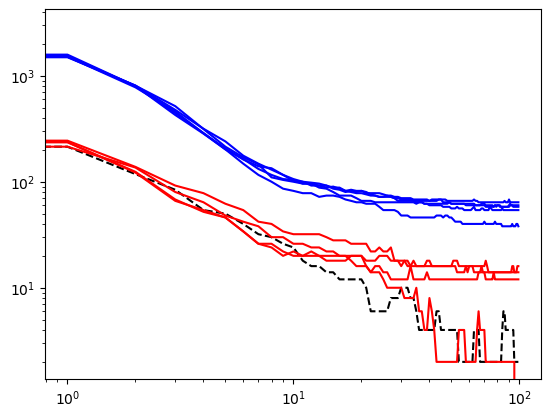

In [4]:
mine = np.array(energies).flatten().min()
plt.plot(energies[0]-mine, 'k--')
for i,e in enumerate(energies[1:]):
    plt.plot(e-mine, 'red' if i < NoEigen-1 else 'blue')
plt.yscale('log')
plt.xscale('log')

In [9]:
sqlatt.export_graph(MODE="pickle")
sqlatt.export_adj_bin()

energies = []
for rep in range(replica):
    np.random.seed(rep)
    random.seed(rep)
    INIT_COND = f"ground_state_{rep}" if rep < NoEigen else "uniform"
    print(rep, INIT_COND)
    ising_dyn = IsingDynamics(
        system=sqlatt, 
        T=T_ising, 
        nstepsIsing=100, 
        IsingIC=INIT_COND,
        MODE_RUN="C0", 
    )
    ising_dyn.init_ising_dynamics()
    ising_dyn.run()
    enepath = f"{sqlatt.isingpath}ene_{sqlatt.stdFname}_T={ising_dyn.T}_{ising_dyn.id_string_isingdyn}.bin"
    ene = np.fromfile(enepath, dtype=float)
    energies.append(ene)

0 ground_state_0
1 ground_state_1
2 ground_state_2
3 ground_state_3
4 ground_state_4
5 uniform
6 uniform
7 uniform
8 uniform


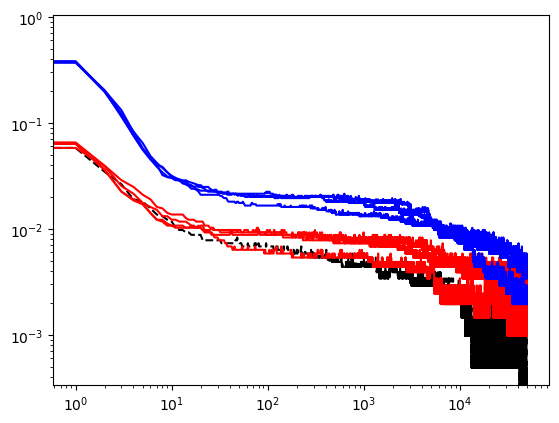

In [10]:
mine = np.array(energies).flatten().min()

plt.plot(energies[0]-mine, 'k--')
for i,e in enumerate(energies[1:]):
    plt.plot(e-mine, 'red' if i < NoEigen-1 else 'blue')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1, 100)

In [7]:



nmax = 100
extra_randinit = 5
initIS = 'spectrum_5'

def neigh_weight_magn(m, node_dict) -> list:
    return [w["weight"] * m[nn] for nn, w in node_dict.items()]

def calcEnergy(m, H=sqlatt.H):
    energy = 0
    for i in range(sqlatt.N):
        neigh=neigh_weight_magn(m, dict(H[i]))
        energy += m[i]*np.sum(neigh)
    return -energy/4.
def __uniform_init():
    return np.random.choice([-1,1], sqlatt.N)
def __eigv_init(i=0):
    return np.sign(sqlatt.eigV[i])

if initIS.startswith('spectrum'):
    states = int(initIS.split('_')[-1])
    tot_init = extra_randinit+states
    sqlatt.compute_k_eigvV(howmany=states)

bigene = []
bigmagn = []
# labels = np.where((eigV[0] < 0))[0]
for replica in range(states+extra_randinit):
    magn = []
    ene = []
    if initIS == 'ground_state': 
        m = __eigv_init()
    if initIS.startswith('spectrum'):
        if replica < states: m = __eigv_init(replica)
        else: m = __uniform_init()
    elif initIS == 'uniform': 
        m = __uniform_init()
    elif initIS == 'ground_state+uniform':
        if replica: m = __uniform_init()
        else: m = __eigv_init()
    elif initIS == 'all_states':
        if replica < sqlatt.N: m = __eigv_init(replica)
        else: m = __uniform_init()
    # sample = rd.sample(H.nodes, N)
    sample = random.sample(list(sqlatt.H.nodes()), sqlatt.N)
    for nsteps in tqdm(range(nmax)):
        magn.append(np.sum(m))
        ene.append(calcEnergy(m))
        for i in range(sqlatt.N):
            node=i
            m_new = -m[node]

            #Metropolis thing
            neigh=neigh_weight_magn(m, dict(sqlatt.H[i]))
            sumneigh = np.sum(np.sum(neigh))
            E_old=-m[node]*sumneigh
            E_new=-m_new*sumneigh

            if E_new<E_old:
                m[node]=m_new
            else:
                r=np.random.uniform(0, 1)
                if (r<np.exp(-(E_new-E_old)/T_ising)):
                    m[node]=m_new
    bigmagn.append(m)
    bigene.append(ene)


100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


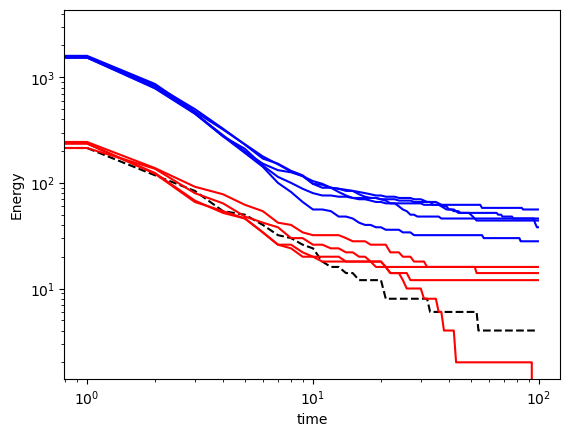

In [8]:
mine = np.array(bigene).flatten().min()
plt.plot(np.array(bigene[0])-mine, c='k', ls='--')
for i in range(1, tot_init):
    plt.plot(np.array(bigene[i])-mine, color='red' if i < states else 'blue')
plt.xscale('log')
plt.ylabel('Energy')
plt.xlabel('time')
# plt.ylim([1,1e3])
# plt.
plt.yscale('log')